# Gradient Boosted Tree

In [1]:
%pylab inline
%matplotlib inline
from matplotlib import pyplot as plt

from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark import *
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = SparkContext()

In [3]:
path = "noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print('First record: ', first)
print('Total number of records: ', num_data)

First record:  ['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Total number of records:  17379


In [4]:
records.cache()

PythonRDD[4] at RDD at PythonRDD.scala:49

In [5]:
def extract_features_dt(record):
    return np.array(record[2:14])
    #return np.array(record[1:8])

In [6]:
def extract_label(record):
    return float(record[-1])

In [7]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))

In [8]:
(trainingData_dt, testData_dt) = data_dt.randomSplit([0.7, 0.3])

In [9]:
data_with_idx_dt = data_dt.zipWithIndex().map(lambda p: (p[1],p[0]))
test_dt = data_with_idx_dt.sample(False, 0.3, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)
train_data_dt = train_dt.map(lambda p: p[1])
test_data_dt = test_dt.map(lambda p: p[1])

In [10]:
model_GBT = GradientBoostedTrees.trainRegressor(train_data_dt,categoricalFeaturesInfo={},numIterations=2,learningRate=0.1, maxDepth=1, maxBins=2)
predictions_GBT = model_GBT.predict(test_data_dt.map(lambda x: x.features))
true_vs_predicted_dt = test_data_dt.map(lambda lp: lp.label).zip(predictions_GBT)
print("Gradient Boosted Tree prediction:" +str(true_vs_predicted_dt.take(5)))

Gradient Boosted Tree prediction:[(16.0, 107.82082560757465), (40.0, 107.82082560757465), (13.0, 107.82082560757465), (1.0, 107.82082560757465), (3.0, 107.82082560757465)]


In [11]:
def squared_error(actual, pred):
    return (pred - actual)**2

In [12]:
def abs_error(actual, pred):
    return np.abs(pred - actual)

In [13]:
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [14]:
mse = true_vs_predicted_dt.map(lambda p: squared_error(p[0], p[1])).mean()
mae = true_vs_predicted_dt.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle = np.sqrt(true_vs_predicted_dt.map(lambda p: squared_log_error(p[0], p[1])).mean())
print ("Gradient Boosted Tree - Mean Squared Error: %2.4f" % mse)
print ("Gradient Boosted Tree - Mean Absolute Error: %2.4f" % mae)
print ("Gradient Boosted Tree - Root Mean Squared Log Error: %2.4f" % rmsle)


Gradient Boosted Tree - Mean Squared Error: 26316.1669
Gradient Boosted Tree - Mean Absolute Error: 123.7684
Gradient Boosted Tree - Root Mean Squared Log Error: 1.3665


In [15]:
def evaluate_gbt(trainData, testData, numIterationsValue, maxDepthValue, maxBinsValue):
    model_GBT = GradientBoostedTrees.trainRegressor(trainData, categoricalFeaturesInfo={}, numIterations=numIterationsValue,maxDepth=maxDepthValue, maxBins=maxBinsValue)
    predictions_GBT = model_GBT.predict(testData.map(lambda x: x.features))
    labelsAndPredictions_GBT = testData.map(lambda lp: lp.label).zip(predictions_GBT)
    rmsleGBT = np.sqrt(labelsAndPredictions_GBT.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
    return rmsleGBT

## Gradient boost tree Iterations

[2, 3, 4]
[0.7985047681926196, 0.7809687600794497, 0.7662460219236575]


Text(0.5,1,'GradientBoosted Trees - Iterators')

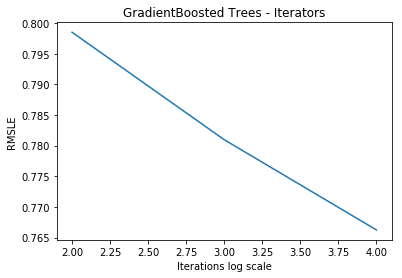

In [16]:
numInterationsParams = [2, 3, 4]

metrics_gbt_iterations = [evaluate_gbt(train_data_dt, test_data_dt, param, 3, 32) for param in numInterationsParams]
print(numInterationsParams)
print(metrics_gbt_iterations)

# Plotting
plot(numInterationsParams, metrics_gbt_iterations)
plt.xlabel('Iterations log scale')
plt.ylabel('RMSLE')
plt.title('GradientBoosted Trees - Iterators')

## Gradient boost tree Max Bins

[4, 5, 6]
[0.8629178813953541, 0.9543362783095837, 0.9240698705038497]


Text(0.5,1,'GradientBoosted Trees - Max Bins')

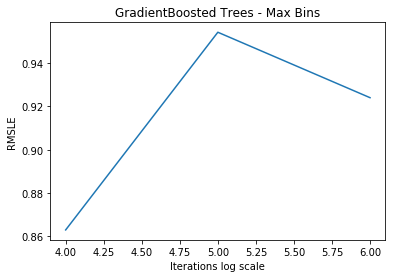

In [17]:
maxBinsParams = [4,5,6]

metrics_gbt_maxBins = [evaluate_gbt(train_data_dt, test_data_dt, 2, 3, param) for param in maxBinsParams]
print(maxBinsParams)
print(metrics_gbt_maxBins)

# Plotting : Decision Tree Max Depth
plot(maxBinsParams, metrics_gbt_maxBins)
plt.xlabel('Iterations log scale')
plt.ylabel('RMSLE')
plt.title('GradientBoosted Trees - Max Bins')

## Gradient boost tree Max Depth

[4, 5, 6]
[0.6790863392427551, 0.6142140344636425, 0.5181946221174568]


Text(0.5,1,'GradientBoosted Trees - Max Depth')

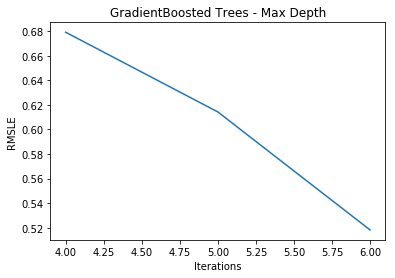

In [18]:
maxDepthParams = [4, 5, 6]

metrics_gbt_maxDepth = [evaluate_gbt(train_data_dt, test_data_dt, 3, param, 32) for param in maxDepthParams]
print(maxDepthParams)
print(metrics_gbt_maxDepth)

# Plotting
plot(maxDepthParams, metrics_gbt_maxDepth)
plt.xlabel('Iterations')
plt.ylabel('RMSLE')
plt.title('GradientBoosted Trees - Max Depth')